<h1 style="font-size:30px;">Fashion MNIST Classification using PyTorch</h1>

In this notebook, we will introduce several new concepts associated with the general problem of classification involving more than two classes. Specifically, in this notebook, we will see how to classify clothing items from the Fashion MNIST database. The Fashion MNIST dataset is included in `torchvision.datasets` and can easily be imported and loaded, as we will see below. Using this dataset, we will demonstrate how to work with image data that represents ten different classes of clothing items and how to develop a network architecture that includes ten neurons whose outputs represent the probability of the classes.



<img src="https://www.dropbox.com/scl/fi/dwxxxfuitptyqj1phxzm3/pytorch-cnn-based-classification-model-with-fashion-mnist_02-1.jpg?rlkey=ao3t3riq0npt6j79vvlp97qhz&st=0bwpnki2&dl=1" width=850>

## Table of Contents
* [1. Prepare the DataLoader](#1.-Prepare-the-DataLoader)
* [2. Dataset Visualization](#2.-Dataset-Visualization)
* [3. Model Architecture](#3.-Model-Architecture)
* [4. Multi Layer Perceptron Model Implementation](#4.-Multi-Layer-Perceptron-Model-Implementation)
* [5. Inference Results](#5.-Inference-Results)
* [6. Conclusion](#6.-Conclusion)

### Import dependencies

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchinfo import summary

In [3]:
def set_seeds():
    # set random seed value
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    # Fix seed to make training deterministic.
    if torch.cuda.is_available():
       torch.cuda.manual_seed(SEED_VALUE)
       torch.cuda.manual_seed_all(SEED_VALUE)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seeds()

In [4]:
# Load the Fashion MNIST dataset without normalization
dataset = datasets.FashionMNIST(root='./data', train=True, transform = transforms.ToTensor(), download=True)

# Stack all the images into a single tensor and compute mean and standard deviation
all_pixels = torch.cat([img.view(-1) for img, _ in dataset]) # -1 means multiply everything i.e the shape (1, 28, 28) => (1*28*28) => (784)
mean = all_pixels.mean().item()
std = all_pixels.std().item()

print(f"Mean: {mean:.4f}, Std: {std:.4f}")

Mean: 0.2860, Std: 0.3530


## 1. Prepare the DataLoader

The Fashion MNIST dataset can be easily downloaded with `torchvision.datasets` and contains 70,000 images partitioned into 60,000 for training and 10,000 for test. We will perform validation and final prediction on the test dataset.


### 1.1. Input Feature Transformation and Normalization

Since we are now working with images as the input, we need to find some logical way to represent the image data as a set of features. A naive approach that actually works fairly well for this dataset is to just assume that the pixel intensities are the features. And one way to transform the image data into a set of features that we can process is to flatten the 2D array into a 1D array. The `28x28` input image thus becomes a 1D array containing `784` features. Notice that we also normalize the pixel intensities to be in the range `[0, 1]`. This is very common when working with image data which helps the model train more efficiently. Also, using the pixel intensities as features is a naive approach that we are using intentionally here to keep things simple. As we will see in subsequent posts, we will learn about convolutional neural networks (CNNs), which use more advanced techniques for representing and processing image data in neural networks.


In [5]:
# Step 1: Download the training set without normalization
raw_transform = transforms.ToTensor()
train_raw_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=raw_transform)

# Step 2: Compute mean and std from the training set
all_pixels = torch.cat([img.view(-1) for img,_ in train_raw_set])
mean = all_pixels.mean().item()
std = all_pixels.std().item()

print(f"Computed mean: {mean:.4f}, Computed STD: {std:.4f}")

# Step 3: Define the new transform using the computed mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std))
])

# Step 4: Reload datasets with proper normalization
train_set = datasets.FashionMNIST(root='./data', download=True, train=True, transform=transform)
val_set = datasets.FashionMNIST(root='./data', download=True, train=False, transform=transform)

print("Total Train Images:", len(train_set))
print("Total Val Images:", len(val_set)) # Test set


Computed mean: 0.2860, Computed STD: 0.3530
Total Train Images: 60000
Total Val Images: 10000


To avoid the MLP network from learning the sequence pattern in the dataset we will shuffle the train dataset. A batch size is determined based on the compute resource available. As this is a relatively less compute intensive training we can set the `batch_size = 64`.

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=64, shuffle=False)

The Fashion MNIST contains 10 classes as follows:

```html
Label	Description
0	    T-shirt/top
1	    Trouser
2	    Pullover
3	    Dress
4	    Coat
5	    Sandal
6	    Shirt
7	    Sneaker
8	    Bag
9	    Ankle boot
```

In [7]:
#class to idx mapping
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

## 2. Dataset Visualization

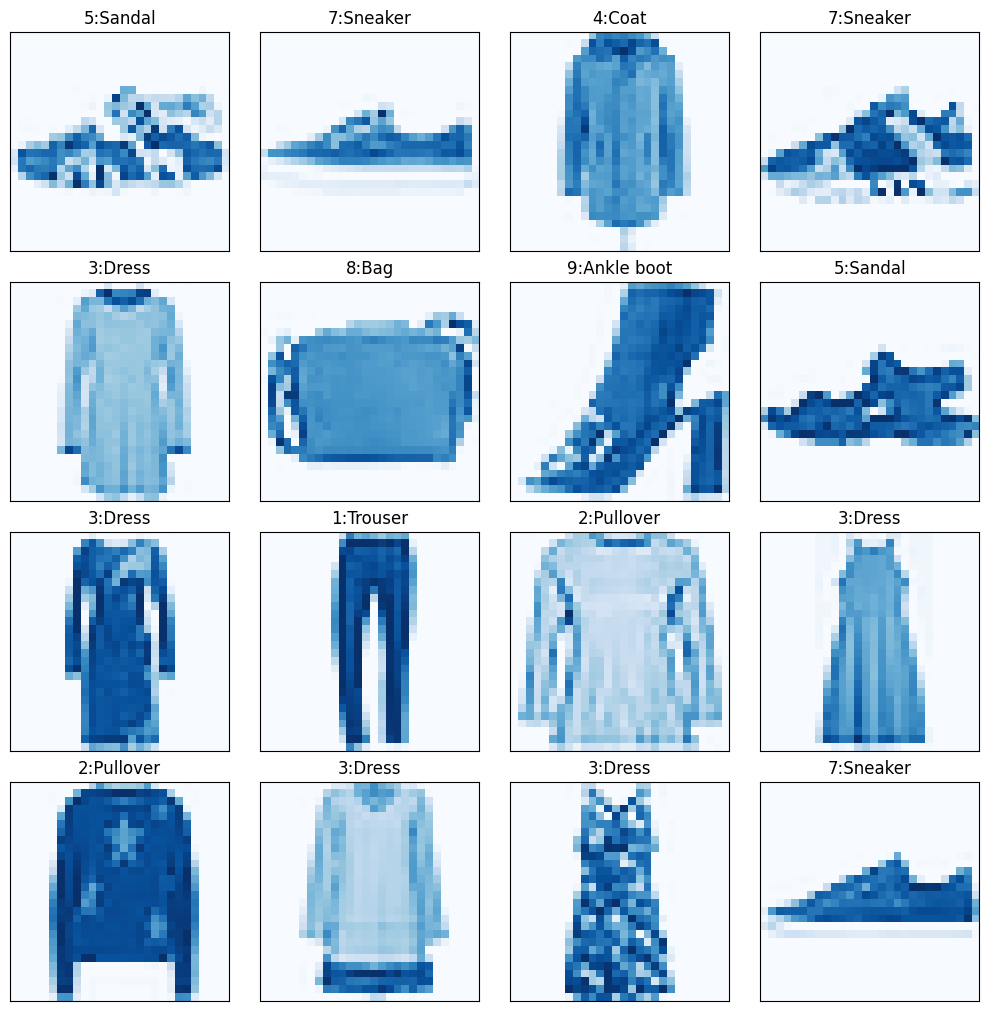

In [8]:
def visualize_dataset(train_loader, num_images=20):
    images, labels = next(iter(train_loader))

    num_cols = 4
    num_rows = int(np.ceil(num_images/num_cols))

    fig = plt.figure(figsize=(10, 10), constrained_layout=True)

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]
        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
        ax.imshow(image.squeeze(), cmap='Blues')
        ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")
    plt.show()

visualize_dataset(train_loader,16)

In [9]:
train_loader

## 3. Model Architecture

### 3.1 Deep Neural Network Architecture

The network architecture shown below has multiple layers. An input layer, five hidden layers, and an output layer. There are several things to note about this architecture.

1. **Input Data**: The image input data is pre-processed (flattened) from a 2-Dimensional array `[28x28]` to 1-Dimensional vector of length `[784x1]` where the elements in this input vector are the normalized pixel intensities.
2. **Hidden Layers**: We have five hidden layers that contain some number of neurons (that we need to specify). Each of the neurons in these layers has a non-linear activation function (e.g., **ReLU**, Sigmoid, etc.).
3. **Output Layer**: We now have ten neurons in the output layer to represent the ten different classes (cloth items: 0 to 9), instead of a single neuron as in the regression example.
4. **Dense Layers**: All the layers in the network are fully connected, meaning that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer. The **weights** associated with each layer are represented in bold to indicate that these are matrices that contain each of the weights for all the connections between adjacent layers in the network.
5. **Softmax Function**: The values from each of the neurons in the output layer are pased through a `log_softmax()` function to produce a probability score for each of the ten cloth items in the dataset.

6. **Network Output**: The network output ($y’$), is a vector of length ten, that contains the probabilities of each output neuron. Predicting the class label simply requires passing ($y'$) through the `argmax` function to determine the index of the predicted label.
6. **Loss Function**: The loss function used is **Negative Log Likelihood Loss**. It is computed from the ground truth labels ($y$) and the output log probabilities of the network ($y'$). Note that $y$ and $y'$ are both matrices whose shape is `(Bacth Size, Num Classes)`.

Although the diagram looks quite a bit different from the single-layer perceptron in the linear regression example, it is fundamentally very similar in terms of the processing that takes place during training and prediction. We still compute a loss based on the predicted output of the network and the ground truth label of the inputs. Backpropagation is used to compute the gradient of the loss with respect to the weights in the network. An Adam optimizer is used to update the weights in the neural network.

<img src='https://www.dropbox.com/scl/fi/56ks2wo5pem1m58djqsi8/MLP-with-Fashion-MNIST-Pipeline.png?rlkey=b7is8m2cz222fa6x88px2ll79&st=qvlv5i5f&dl=1' align='center' width='1000'>

## 4. Multi Layer Perceptron Model Implementation.

The following defines an MLP (Multi-Layer Perceptron) model for classifying images into `10` classes using PyTorch `nn` Module. The model consists of five fully connected layers with `ReLU` activations, batch normalization, and dropout for regularization. The input layer processes `28x28` images (flattened to `784` features), and the output layer uses a log-softmax activation function to produce probabilities for the `10` classes.

Here we use log-softmax at the output layers, as Negative Log Likelihood Loss expects the model's outputs in terms of log probabilities. Dropout is used to prevent overfitting by randomly setting some of the activations to zero during training, and this is compensated by a scale factor to maintain the overall sum of activations.

Activation Functions:

$$\text{ReLU}(x) = (x)^+ = \max(0, x)$$
$$\text{Linear}(x) = x*\text{Weights}^T + \text{bias}$$

In [10]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc0 = nn.Linear(784, 512)
        self.bn0 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.shape[0], 784) # (B, 784) --> (28X28) = 784
        # First fully connected layer with Relu, batch norm
        x = F.relu(self.bn0(self.fc0(x))) # Layer 0
        x = self.dropout(x) # Layer 1: dropout layer

        x = F.relu(self.bn1(self.fc1(x))) # Layer 2
        x = F.relu(self.bn2(self.fc2(x))) # Layer 3
        x = self.dropout(x) # Layer 4: dropout layer
        x = F.relu(self.bn3(self.fc3(x))) # Layer 4

        # Output layer with softmax activation
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [11]:
def make_block(in_features, out_features, dropout=False, p=0.5) -> nn.Sequential:
    layers = [
        nn.Linear(in_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.ReLU()
    ]
    if dropout:
        layers.append(nn.Dropout(p))
    return nn.Sequential(*layers)

class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.flatten = nn.Flatten()

        # Define blocks using make_block function
        self.block1 = make_block(784, 512, dropout=True)
        self.block2 = make_block(512, 256)
        self.block3 = make_block(256, 128, dropout=True)
        self.block4 = make_block(128, 64)

        self.fc_out = nn.Linear(64, num_classes)
        self.softmax = nn.LogSoftmax(dim=1) # Use NLLLoss

    def forward(self, x):
        x = self.flatten(x) # Shape (B, 1, 28, 28) -> (B, 784)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.fc_out(x)
        x = self.softmax(x)
        return x


In [12]:
# Instantiate the model
mlp = MLP(num_classes=10)

Lets look at the parameters (weights) and the output shape form each layer

In [13]:
# A dummy input size of (B, C, H, W) = (1, 1, 28, 28)
print('Display the model summary')
print(summary(mlp, input_size=(1, 1, 28, 28), 
              row_settings=["var_names"],
              col_names=["input_size", "output_size", "num_params"]))

Display the model summary
Layer (type (var_name))                  Input Shape               Output Shape              Param #
MLP (MLP)                                [1, 1, 28, 28]            [1, 10]                   --
├─Flatten (flatten)                      [1, 1, 28, 28]            [1, 784]                  --
├─Sequential (block1)                    [1, 784]                  [1, 512]                  --
│    └─Linear (0)                        [1, 784]                  [1, 512]                  401,920
│    └─BatchNorm1d (1)                   [1, 512]                  [1, 512]                  1,024
│    └─ReLU (2)                          [1, 512]                  [1, 512]                  --
│    └─Dropout (3)                       [1, 512]                  [1, 512]                  --
├─Sequential (block2)                    [1, 512]                  [1, 256]                  --
│    └─Linear (0)                        [1, 512]                  [1, 256]                  131,

#### **4.1. Training Configuration**

In [14]:
criterion = nn.NLLLoss()  # Negative Log Likelihood Loss
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### **4.2 Model Training**

In [15]:
# For training we need both images and labels in either of gpu or cpu
def train(model, train_loader, criterion, optimizer, device):
    model.train() # Set the model to training mode i.e the parameters gets updated
    model.to(device)
    correct_predictions = 0
    running_loss = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    avg_loss = running_loss / len(train_loader) # Avg Loss over each batch not each data point
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [16]:
def validation(model, val_loader, criterion, device):
    model.eval()
    model.to(device)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, dim=1) # (B, Class_id)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader) #Avg Loss over each batch not each data point
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


Let's train the model for 40 epochs and plot the results

In [19]:
def main(model, train_loader, val_loader, epochs=40, 
         device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validation(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Metrics over epochs')
    plt.show()

Epoch 01/40 - Train Loss: 0.3044, Train Accuracy: 0.89% - Val Loss: 0.3016, Val Accuracy: 0.89%
Epoch 02/40 - Train Loss: 0.3073, Train Accuracy: 0.89% - Val Loss: 0.3138, Val Accuracy: 0.89%
Epoch 03/40 - Train Loss: 0.3060, Train Accuracy: 0.89% - Val Loss: 0.3015, Val Accuracy: 0.89%
Epoch 04/40 - Train Loss: 0.3071, Train Accuracy: 0.89% - Val Loss: 0.3071, Val Accuracy: 0.89%
Epoch 05/40 - Train Loss: 0.3047, Train Accuracy: 0.89% - Val Loss: 0.3020, Val Accuracy: 0.89%
Epoch 06/40 - Train Loss: 0.3053, Train Accuracy: 0.89% - Val Loss: 0.3058, Val Accuracy: 0.89%
Epoch 07/40 - Train Loss: 0.3019, Train Accuracy: 0.89% - Val Loss: 0.3133, Val Accuracy: 0.89%
Epoch 08/40 - Train Loss: 0.3025, Train Accuracy: 0.89% - Val Loss: 0.2981, Val Accuracy: 0.89%
Epoch 09/40 - Train Loss: 0.3043, Train Accuracy: 0.89% - Val Loss: 0.2997, Val Accuracy: 0.89%
Epoch 10/40 - Train Loss: 0.3052, Train Accuracy: 0.89% - Val Loss: 0.3073, Val Accuracy: 0.89%
Epoch 11/40 - Train Loss: 0.3036, Train 

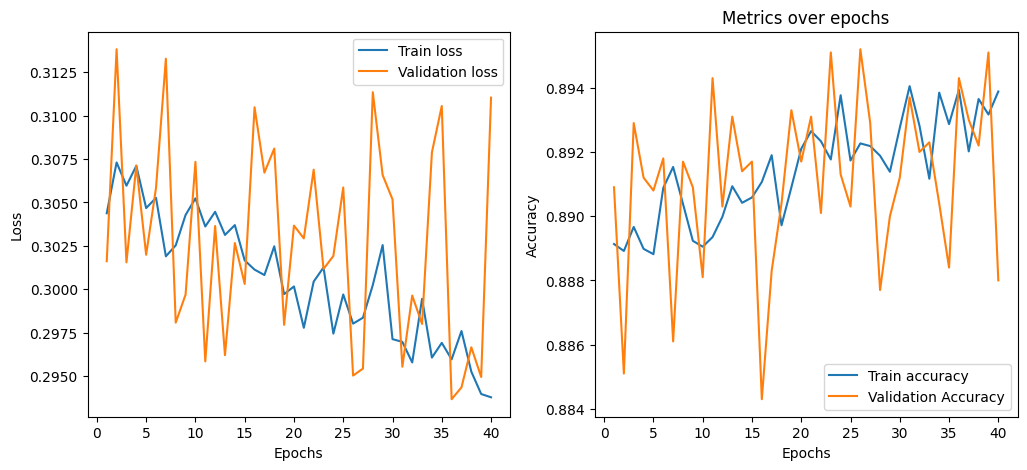

In [20]:
main(mlp, train_loader, val_loader, epochs=num_epochs)

## 5. Inference Results

We can now predict the results for all the test images, as shown in the code below. Here, we call the `next(iter(val_loader))` to retrieve all the predictions of the first batch, and then we select a specific index from the batch outputs and print out the predicted scores for each class. You can experiment with the code below by setting the test index to various values and see how the highest score is usually associated with the correct value indicated by the ground truth.

In [ ]:
i, l = next(iter(val_loader))


In [29]:
i[0].squeeze().size()

torch.Size([28, 28])

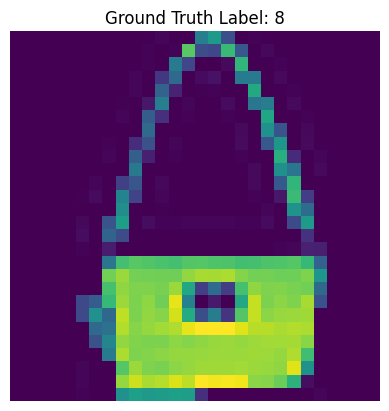

In [59]:
images, gt_labels = next(iter(val_loader))

rand_index = random.choice(range(len(images)))

plt.imshow(images[rand_index].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_index])), fontsize=12)
plt.axis("OFF")
plt.show()

In [60]:
# Formatting
bold = f"\033[1m"
reset = f"\033[0m"

In [61]:
mlp.eval()

with torch.no_grad():
    batch_outputs = mlp(images.to(device))

prob_score_batch = batch_outputs.softmax(dim=1)

prob_score_test_image = prob_score_batch[rand_index]
pred_cls_id = prob_score_test_image.argmax()

print("Predictions for each class on test image: \n")

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
        print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
        print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")

Predictions for each class on test image: 

Class: 0 - T-shirt/top, Probability: 0.000
Class: 1 - Trouser, Probability: 0.000
Class: 2 - Pullover, Probability: 0.000
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.000
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.000
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 0.999
Class: 9 - Ankle boot, Probability: 0.000


#### **5.1. Confusion  matrix**

A confusion matrix is a very common metric that is used to summarize the results of a classification problem. The information is presented in the form of a table or matrix where one axis represents the ground truth labels for each class, and the other axis represents the predicted lables from the network. The entries in the table represent the number of instances from an experiment (which are sometimes represented as percentages rather than counts). Generating a confusion matrix is accomplished by calling the `confusion_matrix` from `sklearn.metrics`, which takes two required arguments which are the list of ground truth labels and the associated predicted lables.

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [66]:
def prediction_batch(model, batch_inputs):
    model.eval()

    batch_outputs = model(batch_inputs)
    with torch.no_grad():
        prob_score_batch = batch_outputs.softmax(dim=1)

    batch_cls_ids = prob_score_batch.argmax(dim=1)

    return batch_cls_ids

In [76]:
val_target_labels, val_pred_labels = [], []
for batch_images, batch_labels in val_loader:
    batch_images = batch_images.to(device)

    batch_cls_ids = prediction_batch(mlp, batch_images)
    val_target_labels.append(batch_labels)
    val_pred_labels.append(batch_cls_ids)

val_target_labels = torch.cat(val_target_labels, dim=0).cpu().numpy()
val_pred_labels = torch.cat(val_pred_labels, dim=0).cpu().numpy()

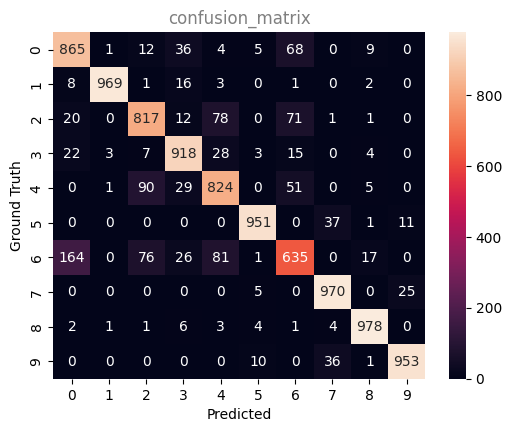

In [84]:
cm = confusion_matrix(y_true=val_target_labels, y_pred=val_pred_labels)

plt.figure(figsize=(6, 4.5))

#Plot the heatmap
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size':10})
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('confusion_matrix', color='gray')
plt.show()

## 6. Conclusion

In this notebook, we introduced a simple approach for how to model image data for use in a densely connected network to perform multinomial classification. In the next notebook, we will learn about Convolutional Neural Networks (CNNs) that are specifically designed to process image data. The following link contains a really nice interactive web-based animation of several well-known CNN architectures, which is a great place to start getting familiar with them.

* 6.1. https://tensorspace.org/html/playground/lenet.html
* 6.2. https://poloclub.github.io/cnn-explainer/